In [1]:
# midfusion_train_complete_fixed.py

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torch.optim import AdamW
from tqdm import tqdm
import cv2
import numpy as np
from pathlib import Path

In [2]:
# ─── Dataset ────────────────────────────────────────────────────────────────────
import yaml
from pathlib import Path
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class RGBDDetectionDataset(Dataset):
    def __init__(self, yaml_path: str, split: str = "train", transforms=None):
        """
        Args:
            yaml_path: Path to dataset.yaml file
            split: "train", "val", or "test"
            transforms: Optional transforms
        """
        # Load YAML
        yaml_path = Path(yaml_path)
        if not yaml_path.exists():
            raise FileNotFoundError(f"YAML file not found: {yaml_path}")
            
        with open(yaml_path, "r") as f:
            data_yaml = yaml.safe_load(f)

        if split not in data_yaml:
            raise ValueError(f"Split '{split}' not found in YAML. Available: {list(data_yaml.keys())}")

        # Get the base directory (where YAML is located)
        base_dir = yaml_path.parent
        
        # Try different path resolution methods
        split_path_str = data_yaml[split]
        
        # Method 1: Relative to YAML file
        if split_path_str.startswith('../'):
            image_dir = base_dir / split_path_str
        # Method 2: Absolute path
        elif Path(split_path_str).is_absolute():
            image_dir = Path(split_path_str)
        # Method 3: Relative to base directory
        else:
            image_dir = base_dir / split_path_str
            
        # If the path points to images directory directly, use it
        if image_dir.name == 'images' and image_dir.exists():
            self.image_dir = image_dir
            split_dir = image_dir.parent
        # If it points to split directory, append images
        elif (image_dir / 'images').exists():
            split_dir = image_dir
            self.image_dir = split_dir / 'images'
        # Try going up one level and finding the split
        else:
            split_dir = base_dir / split
            self.image_dir = split_dir / 'images'
            
        print(f"Looking for images in: {self.image_dir}")
        
        if not self.image_dir.exists():
            raise FileNotFoundError(f"Images directory not found: {self.image_dir}")

        # Find all image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        self.rgb_paths = []
        for ext in image_extensions:
            self.rgb_paths.extend(self.image_dir.glob(f"*{ext}"))
            self.rgb_paths.extend(self.image_dir.glob(f"*{ext.upper()}"))
        
        self.rgb_paths = sorted(self.rgb_paths)
        
        if len(self.rgb_paths) == 0:
            raise ValueError(f"No images found in {self.image_dir}")

        # Set up other directories
        self.depth_dir = split_dir / "depth"
        self.label_dir = split_dir / "labels"
        self.transforms = transforms

        # Class names and count
        self.names = data_yaml.get("names", [])
        self.nc = data_yaml.get("nc", len(self.names))
        
        print(f"Found {len(self.rgb_paths)} images")
        print(f"Depth dir: {self.depth_dir} (exists: {self.depth_dir.exists()})")
        print(f"Label dir: {self.label_dir} (exists: {self.label_dir.exists()})")

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_path   = self.rgb_paths[idx]
        stem       = rgb_path.stem
        depth_path = self.depth_dir / f"{stem}.png"
        label_path = self.label_dir / f"{stem}.txt"

        # Load RGB
        img = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Could not load RGB image: {rgb_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load Depth
        if depth_path.exists():
            d = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED)
            if d is None:
                print(f"Warning: Could not load depth image: {depth_path}, using zeros")
                d = np.zeros(img.shape[:2], dtype=np.float32)
            else:
                d = d.astype(np.float32)
                if len(d.shape) == 3 and d.shape[2] == 3:
                    d = cv2.cvtColor(d, cv2.COLOR_RGB2GRAY)
                elif len(d.shape) == 3 and d.shape[2] == 1:
                    d = d.squeeze(-1)
                d /= (d.max() + 1e-6)
        else:
            print(f"Warning: Depth file not found: {depth_path}, using zeros")
            d = np.zeros(img.shape[:2], dtype=np.float32)
            
        d = d[..., None]   # H×W×1

        # Load Labels (YOLO txt format: cls xc yc w h)
        H, W = img.shape[:2]
        boxes = []
        if label_path.exists():
            try:
                with open(label_path) as f:
                    for line in f:
                        line = line.strip()
                        if line:
                            parts = line.split()
                            if len(parts) >= 5:
                                cls, xc, yc, w, h = map(float, parts[:5])
                                x0 = max(0, (xc - w/2) * W)
                                y0 = max(0, (yc - h/2) * H)
                                x1 = min(W, (xc + w/2) * W)
                                y1 = min(H, (yc + h/2) * H)
                                if x1 > x0 and y1 > y0:  # Valid box
                                    boxes.append([x0, y0, x1, y1, int(cls)])
            except Exception as e:
                print(f"Warning: Error reading label file {label_path}: {e}")

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
        else:
            boxes = torch.zeros((0, 5), dtype=torch.float32)

        # Convert to tensors
        rgb_t   = torch.from_numpy(img.transpose(2, 0, 1))   # 3×H×W
        depth_t = torch.from_numpy(d.transpose(2, 0, 1))     # 1×H×W

        target = {
            "boxes":  boxes[:, :4],
            "labels": boxes[:, 4].long() + 1   # shift classes for FasterRCNN (0=background)
        }

        if self.transforms:
            rgb_t, depth_t, target = self.transforms(rgb_t, depth_t, target)

        return rgb_t, depth_t, target

In [3]:
# ─── Collate Function ───────────────────────────────────────────────────────

def collate_fn(batch):
    rgbs, depths, targets = zip(*batch)
    return list(rgbs), list(depths), list(targets)

In [4]:
# ─── Mid‐Level Fusion Backbone ─────────────────────────────────────────────────

class MidLevelFusionBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        # RGB ResNet50
        res_r = resnet50(pretrained=True)
        # Depth ResNet50 (single-channel)
        res_d = resnet50(pretrained=False)
        res_d.conv1 = nn.Conv2d(1, res_d.conv1.out_channels,
                                kernel_size=7, stride=2, padding=3, bias=False)

        return_layers = {"layer1":"c2", "layer2":"c3", "layer3":"c4", "layer4":"c5"}
        self.rgb_extractor   = IntermediateLayerGetter(res_r, return_layers)
        self.depth_extractor = IntermediateLayerGetter(res_d, return_layers)

        # FPN for concatenated features (C2–C5)
        in_chs = [256*2, 512*2, 1024*2, 2048*2]
        self.fpn = FeaturePyramidNetwork(in_channels_list=in_chs, out_channels=256)
        self.out_channels = 256

    def forward(self, x):
        # x may be a list of Tensors [4×H×W] or a single Tensor [B,4,H,W]
        if isinstance(x, (list, tuple)):
            x = torch.stack(x, dim=0)
        # now x: [B,4,H,W]
        rgb   = x[:, :3, :, :]
        depth = x[:, 3:4, :, :]

        feats_r = self.rgb_extractor(rgb)
        feats_d = self.depth_extractor(depth)
        fused   = {name: torch.cat([feats_r[name], feats_d[name]], dim=1)
                   for name in feats_r}
        return self.fpn(fused)

In [5]:
 # ─── Model Factory ─────────────────────────────────────────────────────────────

def build_midfusion_fasterrcnn(num_classes: int):
    backbone = MidLevelFusionBackbone()

    # 4 FPN levels → one size and aspect_ratios tuple per level
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,)),
        aspect_ratios=((0.5,1.0,2.0),) * 4
    )

    # ROI pooling on the 4 FPN maps: c2–c5
    roi_pool = MultiScaleRoIAlign(
        featmap_names=['c2','c3','c4','c5'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pool
    )
    # Normalize 4th channel (depth) with zero-mean
    model.transform.image_mean = [0.485, 0.456, 0.406, 0.0]
    model.transform.image_std  = [0.229, 0.224, 0.225, 1.0]
    return model

In [6]:
# ─── Training & Early Stopping ─────────────────────────────────────────────────

def train_one_epoch(model, loader, optimizer, device, epoch):
    model.train()
    pbar = tqdm(loader, desc=f"Epoch {epoch} [train]", unit="batch")
    total = 0.0
    for rgbs, depths, targets in pbar:
        inputs = [torch.cat([r, d], dim=0).to(device)
                  for r, d in zip(rgbs, depths)]
        tgts = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(inputs, tgts)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
        pbar.set_postfix(train_loss=f"{loss.item():.4f}")
    pbar.close()
    return total / len(loader)


In [7]:
@torch.no_grad()
def eval_loss(model, loader, device):
    # keep train() so loss_dict is returned
    model.train()
    pbar = tqdm(loader, desc="[val]  ", unit="batch")
    total = 0.0
    for rgbs, depths, targets in pbar:
        inputs = [torch.cat([r, d], dim=0).to(device)
                  for r, d in zip(rgbs, depths)]
        tgts   = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss = sum(model(inputs, tgts).values()).item()
        total += loss
        pbar.set_postfix(val_loss=f"{loss:.4f}")
    pbar.close()
    return total / len(loader)


In [8]:
if __name__ == "__main__":
    # ── Hyperparameters ─────────────────────────────────────────────────────────
    YAML_PATH   = "dataset/data.yaml"   # path to dataset.yaml
    BATCH_SIZE  = 8
    LR          = 1e-4
    WD          = 1e-4
    MAX_EPOCHS  = 20
    PATIENCE    = 5
    SEED        = 42
    DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # ──────────────────────────────────────────────────────────────────────────────

    # Create datasets for each split
    train_ds = RGBDDetectionDataset(YAML_PATH, split="train")
    val_ds   = RGBDDetectionDataset(YAML_PATH, split="val")
    test_ds  = RGBDDetectionDataset(YAML_PATH, split="test")

    # Number of classes (add 1 for background)
    NUM_CLASSES = train_ds.nc + 1  
    print(NUM_CLASSES)
    
    print(f"Dataset sizes - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=0, collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=0, collate_fn=collate_fn)

    model     = build_midfusion_fasterrcnn(NUM_CLASSES).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    best_val_loss     = float("inf")
    epochs_no_improve = 0

    for epoch in range(1, MAX_EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, DEVICE, epoch)
        vl_loss = eval_loss(model, val_loader, DEVICE)

        print(f"Epoch {epoch:02d}: train_loss={tr_loss:.4f}, val_loss={vl_loss:.4f}")

        if vl_loss < best_val_loss:
            best_val_loss     = vl_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "midfusion_best1.pth")
            print("  ↳ Validation loss improved; model saved.")
        else:
            epochs_no_improve += 1
            print(f"  ↳ No improvement for {epochs_no_improve}/{PATIENCE} epochs.")
            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch}.")
                break

    print(f"Training complete. Best val_loss: {best_val_loss:.4f}")
    
    # Optional: Evaluate on test set
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load("midfusion_best1.pth"))
    test_loss = eval_loss(model, test_loader, DEVICE)
    print(f"Test loss: {test_loss:.4f}")


Looking for images in: dataset\train\images
Found 126 images
Depth dir: dataset\train\depth (exists: True)
Label dir: dataset\train\labels (exists: True)
Looking for images in: dataset\val\images
Found 32 images
Depth dir: dataset\val\depth (exists: True)
Label dir: dataset\val\labels (exists: True)
Looking for images in: dataset\test\images
Found 18 images
Depth dir: dataset\test\depth (exists: True)
Label dir: dataset\test\labels (exists: True)
4
Dataset sizes - Train: 126, Val: 32, Test: 18


v:\model\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
v:\model\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
v:\model\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
[val]  : 100%|██████████| 4/4 [00:00<00:00,  4.51batch/s, val_loss=0.4446]


Epoch 01: train_loss=1.0641, val_loss=0.5325
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.90batch/s, val_loss=0.3867]


Epoch 02: train_loss=0.3601, val_loss=0.4335
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.94batch/s, val_loss=0.2724]


Epoch 03: train_loss=0.2470, val_loss=0.3347
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.85batch/s, val_loss=0.2559]


Epoch 04: train_loss=0.2024, val_loss=0.3067
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.79batch/s, val_loss=0.2416]


Epoch 05: train_loss=0.1637, val_loss=0.2934
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.01batch/s, val_loss=0.2263]


Epoch 06: train_loss=0.1518, val_loss=0.3297
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.44batch/s, val_loss=0.1796]


Epoch 07: train_loss=0.1328, val_loss=0.2586
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.01batch/s, val_loss=0.2136]


Epoch 08: train_loss=0.1173, val_loss=0.2886
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.98batch/s, val_loss=0.2303]


Epoch 09: train_loss=0.1080, val_loss=0.2933
  ↳ No improvement for 2/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.74batch/s, val_loss=0.1837]


Epoch 10: train_loss=0.0964, val_loss=0.2572
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.95batch/s, val_loss=0.1706]


Epoch 11: train_loss=0.0798, val_loss=0.2551
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.92batch/s, val_loss=0.2269]


Epoch 12: train_loss=0.0758, val_loss=0.3049
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.99batch/s, val_loss=0.1712]


Epoch 13: train_loss=0.0827, val_loss=0.2473
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.96batch/s, val_loss=0.1508]


Epoch 14: train_loss=0.0804, val_loss=0.2493
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.94batch/s, val_loss=0.1805]


Epoch 15: train_loss=0.0677, val_loss=0.2431
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.92batch/s, val_loss=0.1651]


Epoch 16: train_loss=0.0608, val_loss=0.2408
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.91batch/s, val_loss=0.1758]


Epoch 17: train_loss=0.0604, val_loss=0.2619
  ↳ No improvement for 1/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  2.94batch/s, val_loss=0.1793]


Epoch 18: train_loss=0.0623, val_loss=0.2444
  ↳ No improvement for 2/5 epochs.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.68batch/s, val_loss=0.1558]


Epoch 19: train_loss=0.0566, val_loss=0.2262
  ↳ Validation loss improved; model saved.


[val]  : 100%|██████████| 4/4 [00:01<00:00,  3.71batch/s, val_loss=0.1643]


Epoch 20: train_loss=0.0638, val_loss=0.2424
  ↳ No improvement for 1/5 epochs.
Training complete. Best val_loss: 0.2262

Evaluating on test set...


[val]  : 100%|██████████| 3/3 [00:00<00:00,  4.68batch/s, val_loss=0.0966]

Test loss: 0.1801


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import numpy as np

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0.0

@torch.no_grad()
def evaluate_model_for_confusion_matrix(model, dataloader, device, 
                                      iou_threshold=0.5, confidence_threshold=0.5):
    """Evaluate model and return predictions and targets for confusion matrix"""
    model.eval()
    all_preds = []
    all_targets = []
    
    print("Evaluating model...")
    for batch_idx, (rgbs, depths, targets) in enumerate(tqdm(dataloader)):
        # Prepare inputs
        inputs = [torch.cat([r, d], dim=0).to(device) for r, d in zip(rgbs, depths)]
        
        # Get predictions
        outputs = model(inputs)
        
        # Process each image in batch
        for output, target in zip(outputs, targets):
            pred_boxes = output['boxes']
            pred_labels = output['labels']  
            pred_scores = output['scores']
            
            target_boxes = target['boxes'].to(device)
            target_labels = target['labels'].to(device)
            
            # Filter predictions by confidence
            valid_preds = pred_scores >= confidence_threshold
            pred_boxes = pred_boxes[valid_preds]
            pred_labels = pred_labels[valid_preds]
            pred_scores = pred_scores[valid_preds]
            
            # Match predictions to targets
            used_targets = set()
            
            # For each prediction, find best matching target
            for pred_box, pred_label in zip(pred_boxes, pred_labels):
                best_iou = 0
                best_target_idx = -1
                
                for j, (target_box, target_label) in enumerate(zip(target_boxes, target_labels)):
                    if j in used_targets:
                        continue
                    
                    iou = calculate_iou(pred_box.cpu().numpy(), target_box.cpu().numpy())
                    if iou > best_iou and iou >= iou_threshold:
                        best_iou = iou
                        best_target_idx = j
                
                if best_target_idx != -1:
                    # True positive - correct detection
                    all_preds.append(pred_label.item())
                    all_targets.append(target_labels[best_target_idx].item())
                    used_targets.add(best_target_idx)
                else:
                    # False positive - predicted something that doesn't exist
                    all_preds.append(pred_label.item())
                    all_targets.append(0)  # Background class for FP
            
            # Add unmatched targets as false negatives
            for j, target_label in enumerate(target_labels):
                if j not in used_targets:
                    all_preds.append(0)  # Background class for FN
                    all_targets.append(target_label.item())
    
    return all_preds, all_targets

def plot_confusion_matrix(all_preds, all_targets, class_names):
    """Plot confusion matrix"""
    # Create class names including background
    full_class_names = ['Background'] + class_names
    
    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_preds, 
                         labels=range(len(full_class_names)))
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=full_class_names,
               yticklabels=full_class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print("=" * 60)
    report = classification_report(
        all_targets, all_preds,
        labels=range(len(full_class_names)),
        target_names=full_class_names,
        zero_division=0
    )
    print(report)
    
    return cm

Classes: ['bud', 'mouse', 'stepler']
Number of classes (including background): 4
Creating model architecture...


v:\model\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
v:\model\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
v:\model\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading trained weights...
✓ Model loaded successfully!
Loading test dataset...
Looking for images in: dataset\test\images
Found 18 images
Depth dir: dataset\test\depth (exists: True)
Label dir: dataset\test\labels (exists: True)
Test dataset size: 18
Generating confusion matrix...
Evaluating model...


100%|██████████| 5/5 [00:00<00:00,  9.26it/s]


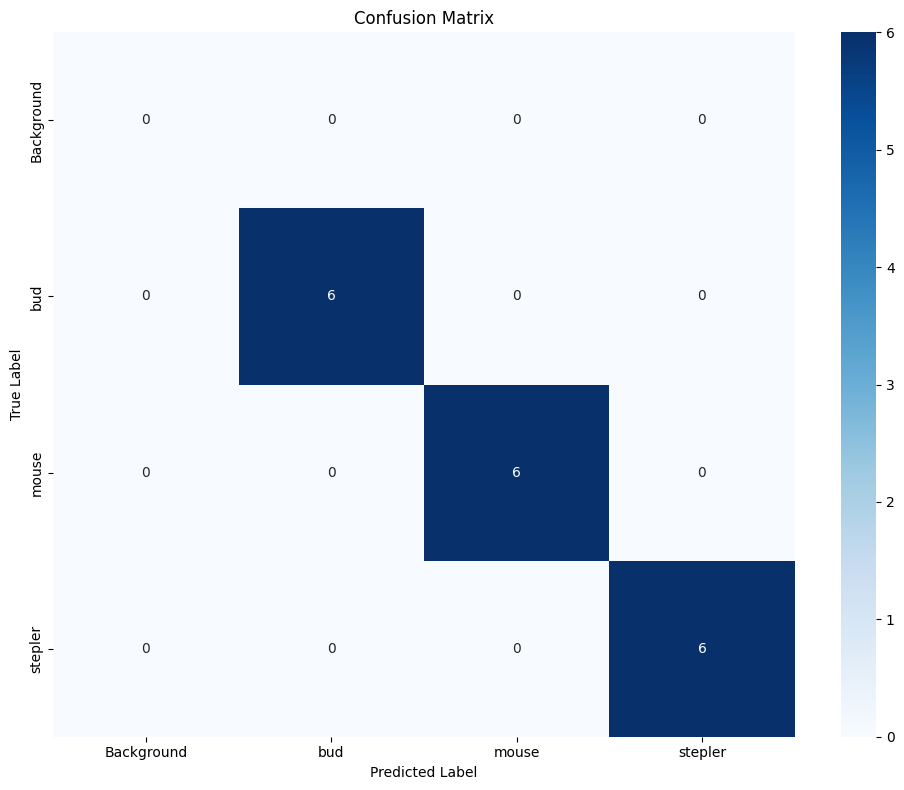


Classification Report:
              precision    recall  f1-score   support

  Background       0.00      0.00      0.00         0
         bud       1.00      1.00      1.00         6
       mouse       1.00      1.00      1.00         6
     stepler       1.00      1.00      1.00         6

    accuracy                           1.00        18
   macro avg       0.75      0.75      0.75        18
weighted avg       1.00      1.00      1.00        18

Confusion matrix generated successfully!


In [18]:
# Complete code for loading model and generating confusion matrix

# Step 1: Load configuration
import yaml
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
YAML_PATH = "dataset/data.yaml"

# Load class information
try:
    with open(YAML_PATH, 'r') as f:
        data_yaml = yaml.safe_load(f)
    class_names = data_yaml['names']
    NUM_CLASSES = data_yaml['nc'] + 1  # +1 for background
    print(f"Classes: {class_names}")
    print(f"Number of classes (including background): {NUM_CLASSES}")
except:
    # Fallback if YAML not available
    class_names = ['class1', 'class2', 'class3']  # Replace with your actual class names
    NUM_CLASSES = 4  # Replace with your actual number (including background)
    print(f"Using fallback classes: {class_names}")

# Step 2: Recreate model architecture
print("Creating model architecture...")
model = build_midfusion_fasterrcnn(NUM_CLASSES)

# Step 3: Load trained weights
print("Loading trained weights...")
state_dict = torch.load("midfusion_best1.pth", map_location=DEVICE)
model.load_state_dict(state_dict)
model.to(DEVICE)
model.eval()
print("✓ Model loaded successfully!")


print("Loading test dataset...")
test_dataset = RGBDDetectionDataset(YAML_PATH, split="test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, 
                        collate_fn=collate_fn, num_workers=0)
print(f"Test dataset size: {len(test_dataset)}")

print("Generating confusion matrix...")
all_preds, all_targets = evaluate_model_for_confusion_matrix(
    model, test_loader, DEVICE, 
    iou_threshold=0.5, 
    confidence_threshold=0.5
)

if len(all_preds) > 0:
    cm = plot_confusion_matrix(all_preds, all_targets, class_names)
    print("Confusion matrix generated successfully!")
else:
    print("No predictions found. Check your dataset and thresholds.")



# Example usage for single image test:
# test_single_image(model, "path/to/rgb.png", "path/to/depth.png", DEVICE)

In [30]:
# Step 6: Test on a single image (if you want to verify the model works)
def test_single_image(model, rgb_path, depth_path, device, save_path=None):
    """Test model on a single image and draw bounding boxes"""
    import cv2
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # Load images
    rgb = cv2.imread(rgb_path)
    if rgb is None:
        print(f"Could not load RGB image: {rgb_path}")
        return
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    
    depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
    if depth is None:
        print(f"Could not load depth image: {depth_path}")
        return
    
    if depth.ndim == 2:
        depth = depth[..., None]
    
    # Convert to tensors
    rgb_t = torch.from_numpy(rgb.copy()).permute(2, 0, 1).float()
    depth_t = torch.from_numpy(depth.copy()).permute(2, 0, 1).float()
    
    rgb_t = rgb_t / 255.0
    depth_t = depth_t / 255.0


    # Combine and add batch dimension
    input_tensor = torch.cat([rgb_t, depth_t], dim=0).unsqueeze(0).to(device)
    
    # Get predictions
    with torch.no_grad():
        predictions = model(input_tensor)[0]
    
    print(predictions)
    
    # Draw bounding boxes using OpenCV for saving
    rgb_copy = rgb.copy()
    for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):

        if score < 0.6:  # Skip low confidence predictions
            continue
        
        x1, y1, x2, y2 = box.cpu().numpy().astype(int)
        class_idx = label.item() - 1  # Convert back from FasterRCNN format
        if 0 <= class_idx < len(class_names):
            class_name = class_names[class_idx]
        else:
            class_name = f"Class{class_idx}"
        
        # Draw rectangle
        cv2.rectangle(rgb_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)  # blue box
        cv2.putText(rgb_copy, f"{class_name} {score:.2f}", 
                    (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    # Show result with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_copy)
    plt.axis('off')
    plt.title("Model Predictions with Bounding Boxes")
    plt.show()
    
    # Optionally save the image
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(rgb_copy, cv2.COLOR_RGB2BGR))
        print(f"Saved output with boxes at: {save_path}")
    print(class_name)
    print(f"Found {len(predictions['boxes'])} detections")
    print(f"Confidence scores: {predictions['scores'].cpu().numpy()}")

In [39]:
test_single_image(model, r"C:\Users\Guest_\Pictures\Screenshots\test.png", r"V:\model\temp\work\Depth\depth_4.png", DEVICE)

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 467 but got size 480 for tensor number 1 in the list.